In [13]:
import yfinance as yf

import matplotlib.pyplot as plt
import math
import pandas as pd
import numpy as np
import seaborn as sns

from ta.momentum import roc
from ta.momentum import RSIIndicator,rsi
from ta.trend import wma_indicator, ema_indicator
from ta.utils import dropna

import warnings
warnings.filterwarnings('ignore')

# Trading Strategy

Combination of a momentum indicator **Coppock Curve** with a mean-reversion indictor **RSI**. 

Dual-indicator approach that leverages the strengths of both the Coppock Curve and the RSI to maximize trading opportunities. This strategy is designed to harness the Coppock Curve's ability to identify long-term trend reversals and the RSI's sensitivity to short-term price movements. This combination allows traders to align themselves with the overall market momentum while pinpointing optimal entry points for trades. Ultimately, offering a more holistic view of the market and potentially filter out false signals.


## Signals
We will use Coppock Curve and RSI to each generate a value. 1 or -1. 

### Coppock curve [1,-1]
1 is generated when Coppock Curve crosses above zero. This indicates that the momentum has shifted from negative (bearish) to positive (bullish), suggesting that it might be a good time to buy.
-1 is generated when the Coppock Curve crosses below zero. This suggests that the momentum has shifted from positive (bullish) to negative (bearish), which might indicate that it might be a good time to short.

### RSI [1,-1]
40/70 We will use the values 40 to indicate oversold and 70 to indicate overbought.
1 is generated when RSI crossed above 40 from below or if RSI >50
-1 is generated when RSI crossed below 70 from above or if RSI <50

Combining the values generated by Coppock Curve and RSI
We will be able to generate the absolute value denoting the confidence and direction of the signal

- **Strong Buy Signal**: (1,1) 2
- **Weak Buy Signal**: (1,-1) 0
- **Strong Sell Signal**: (-1,1) 0
- **Weak Sell Signal**: (-1,-1) -2

We will then convert the value generated to get the weights relative to the Portfolio

Legend :
2 = 3 weight  
0 = 2 weight
-2 = 1 weight

We will then use the weights given to the stock to generate the capital allocated for each stock.
Capital of Stock x = Weights of Stock x / Sum of weights of all stock

## Variations of Coppock Curve

1. **Coppock Curve with standard sets of 2 periods**: The standard Coppock Curve uses a 14-day period for the long Rate of Change (RoC) and an 11-day period for the short RoC. An alternative configuration might be to use a 21-day period for the long RoC and a 5-day period for the short RoC.

2. **Coppock Curve with different smoothing constants**: The standard Coppock Curve uses a 10-period Weighted Moving Average (WMA) for smoothing.
Alternative configurations might use a different period for the WMA.

3. The standard Coppock Curve uses a **Weighted Moving Average (WMA)** for smoothing.

In [14]:
# Indicator Logic

def get_cc_wma(df,roc1_n,roc2_n,wma_lookback):
    cc_wma = wma_indicator((roc(close=df['Close_Price'], window=roc1_n,fillna= False)) + (roc(close=df['Close_Price'], window=roc2_n,fillna= False)), window=wma_lookback,fillna= False)
    return cc_wma

def get_rsi(df,window):
    rsi_indicator = rsi(close=df['Close_Price'], window=window,fillna= False)
    return rsi_indicator

def CC_RSI_strategy(df,num):
    wma = 10
    for var in range(1,num+1):
        df[f'cc_{var}'] = get_cc_wma(df, 14, 11, wma)
        wma += 40
    df['rsi_14'] = get_rsi(df, 14)
    df = df.dropna()

    for var in range(1,num+1):
        cc_crossed_above_zero = False
        rsi_crossed_40_below = False
        rsi_crossed_70_above = False
        val = [1]
        for day in range(1,len(df)):
            # Generate strat
            cc_current = df.iloc[day][f'cc_{var}']
            cc_prev = df.iloc[day-1][f'cc_{var}']
            rsi_current = df.iloc[day]['rsi_14']
            rsi_prev = df.iloc[day-1]['rsi_14']
            if cc_crossed_above_zero:
                # check rsi
                if rsi_crossed_40_below or rsi_current > 50:
                    val.append(3)
                elif rsi_crossed_70_above or rsi_current < 50:
                    val.append(2)
                else:
                    val.append(1)

                if cc_current <= 0:
                    cc_crossed_above_zero = False
                if rsi_current < 40:
                    rsi_crossed_40_below = False
                if rsi_current > 70:
                    rsi_crossed_70_above = False
                # continue
            else:
                if rsi_crossed_40_below or rsi_current > 50:
                    val.append(2)
                elif rsi_crossed_70_above or rsi_current < 50:
                    val.append(1)
                else:
                    val.append(3)  
            # Check if CC has crossed above zero
            if cc_current > 0 and cc_prev <= 0:
                cc_crossed_above_zero = True
            else:
                cc_crossed_above_zero = False

            # Check if RSI has crossed 40 from below
            if rsi_current > 40 and rsi_prev <= 40:
                rsi_crossed_40_below = True
            else:
                rsi_crossed_40_below = False

            # Check if RSI has crossed 70 from above
            if rsi_current < 70 and rsi_prev >= 70:
                rsi_crossed_70_above= True
            else:
                rsi_crossed_70_above = False

        df[f'cc_{var}_val'] = val
    return df
    

In [15]:
class Portfolio():
    def __init__(self, stocks, capital):
        self.stocks = stocks
        self.dataframe = pd.DataFrame() #load this dataframe sequentially
        self.initial_capital = capital # this is the initial capital you want to trade with
        self.capital = capital # this capital will change depending on trades

In [16]:
class Stock():

  def __init__(self, symbol, start, end, interval, transcation_cost, strategy, verbose = True):

    self.symbol = symbol
    self.start = start
    self.end = end
    self.interval = interval
    self.transaction_cost = transcation_cost # the transaction cost for trading
    self.quantity = 0 # quantities to buy/sell
    self.position = 0 # the trades in progress, long or short
    self.trades = 0 # Number of trades
    self.verbose = verbose # if you want to see detailed output (logs)
    self.strategy = strategy # define the strategy

    self.prepare_data() # prepares the data

  def prepare_data(self):
    # since we are building a common class for all types of strategy, we will not calcualte the moving averages now.
    # we will calculate the returns though.
    # Since most strategies utilise close prices we are only factoring close price. However, you can alter acoordingly.

    stock_data = yf.Ticker(self.symbol)
    hist_stock = stock_data.history(start = self.start, end = self.end, interval = self.interval)
    bt_data = pd.DataFrame()
    bt_data["Close_Price"] = hist_stock["Close"]
    bt_data["Open_Price"] = hist_stock["Open"]
    bt_data["Return"] = np.log(bt_data["Close_Price"] / bt_data["Close_Price"].shift(1))
    bt_data = bt_data.dropna()
    bt_data.index = bt_data.index.date
    self.data = bt_data
    
  def close_graph(self):
    plt.figure(figsize=(15, 5))
    plt.plot(self.data["Close_Price"] ,color='black', label='Price', linestyle='dashed')
    plt.xlabel("Days")
    plt.ylabel("Price")
    plt.title("Close Prices of {}".format(self.symbol))
    plt.legend()
    plt.grid()
    plt.show()

  def return_date_price(self, bar):

    # A bar is a unit of data at a given time, depends on the interval you choose, it provides you OHLCV and time info
    # Since we have modeled close prices, we will get the price and date

    date = str(self.data.index[bar])[:10] #First 10 contains the date elements, rest is time
    price = self.data.Close_Price.iloc[bar]
    return date, price

  def load_strategy(self,num):
    self.data = self.strategy(self.data,num)


In [17]:
yf.Ticker("NVDA").history(start = '2010-01-01', end = '2016-12-31', interval = '1d')

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2010-01-04 00:00:00-05:00,4.245387,4.270616,4.153645,4.240800,80020400,0.0,0.0
2010-01-05 00:00:00-05:00,4.224744,4.348596,4.224744,4.302725,72864800,0.0,0.0
2010-01-06 00:00:00-05:00,4.300433,4.339424,4.259149,4.330249,64916800,0.0,0.0
2010-01-07 00:00:00-05:00,4.307313,4.325662,4.213277,4.245387,54779200,0.0,0.0
2010-01-08 00:00:00-05:00,4.210984,4.284378,4.185755,4.254562,47816800,0.0,0.0
...,...,...,...,...,...,...,...
2016-12-23 00:00:00-05:00,26.215175,27.067821,26.188067,27.053036,64769200,0.0,0.0
2016-12-27 00:00:00-05:00,27.614892,28.920969,27.407892,28.911112,119427200,0.0,0.0
2016-12-28 00:00:00-05:00,29.472971,29.554294,26.784426,26.922426,229576400,0.0,0.0


In [28]:
# First load the stock

NVDA = Stock(symbol = 'NVDA', start = '2010-01-01', end = '2016-12-31', interval = '1d', transcation_cost = 0, strategy=CC_RSI_strategy, verbose=True)
AAPL = Stock(symbol = 'AAPL', start = '2010-01-01', end = '2016-12-31', interval = '1d', transcation_cost = 0, strategy=CC_RSI_strategy, verbose = True)
AMZN = Stock(symbol = 'AMZN', start = '2010-01-01', end = '2016-12-31', interval = '1d', transcation_cost = 0, strategy=CC_RSI_strategy, verbose = True)
NFLX = Stock(symbol = 'NFLX', start = '2010-01-01', end = '2016-12-31', interval = '1d', transcation_cost = 0, strategy=CC_RSI_strategy, verbose = True)
GOOGL = Stock(symbol = 'GOOGL', start = '2010-01-01', end = '2016-12-31', interval = '1d', transcation_cost = 0, strategy=CC_RSI_strategy, verbose = True)

# Load the Portfolio with stocks
CC_RSI_portfolio = Portfolio(
    {'NVDA' : NVDA,
    'AAPL' : AAPL,
    'AMZN' : AAPL,
    'NFLX' : NFLX,
    'GOOGL' : GOOGL
    }, 500000)


var = 3
CC_RSI_portfolio.stocks['NVDA'].load_strategy(var)
CC_RSI_portfolio.stocks['AAPL'].load_strategy(var)
CC_RSI_portfolio.stocks['AMZN'].load_strategy(var)
CC_RSI_portfolio.stocks['NFLX'].load_strategy(var)
CC_RSI_portfolio.stocks['GOOGL'].load_strategy(var)
#Example of calls
# CC_RSI_portfolio.stocks['AAPL'].data
# CC_RSI_portfolio.stocks['AAPL'].load_strategy()
# CC_RSI_portfolio.stocks['AAPL'].close_graph()
# CC_RSI_portfolio.stocks['AAPL'].return_date_price(1) # return the data of day 1
# CC_RSI_portfolio.stocks['AAPL'].realised_balance(1)
# CC_RSI_portfolio.stocks['AAPL'].unrealised_balance(1)

In [29]:
CC_RSI_portfolio.stocks['NVDA'].data

,Close_Price,Open_Price,Return,cc_1,cc_2,cc_3,rsi_14,cc_1_val,cc_2_val,cc_3_val
2010-06-03,2.912827,2.857781,-0.001573,-17.783442,-20.190385,-12.365089,37.099719,1,1,1
2010-06-04,2.775213,2.827965,-0.048396,-16.067815,-20.087194,-12.446897,32.639561,1,1,1
2010-06-07,2.637599,2.786681,-0.050858,-16.108847,-20.261833,-12.694129,28.898147,1,1,1
2010-06-08,2.564205,2.626131,-0.028221,-17.043369,-20.578171,-13.029406,27.113074,1,1,1
2010-06-09,2.502278,2.577966,-0.024447,-18.617304,-20.993972,-13.431802,25.672138,1,1,1
...,...,...,...,...,...,...,...,...,...,...
2016-12-23,27.053030,26.215169,0.024622,26.203564,25.418846,20.296434,78.796688,2,2,2
2016-12-27,28.911118,27.614897,0.066427,32.595064,26.654567,21.122900,83.513456,2,2,2
2016-12-28,26.922430,29.472976,-0.071266,34.857316,27.200317,21.577610,66.470192,2,2,2
2016-12-29,27.459644,25.850460,0.019758,37.176997,27.891729,22.128163,68.349274,2,2,2


In [30]:
CC_RSI_portfolio.stocks['AAPL'].data

,Close_Price,Open_Price,Return,cc_1,cc_2,cc_3,rsi_14,cc_1_val,cc_2_val,cc_3_val
2010-10-28,9.253096,9.335246,-0.008449,12.426863,13.106494,8.674417,61.218828,1,1,1
2010-10-29,9.123958,9.222479,-0.014054,9.981401,12.778347,8.594040,54.794435,2,2,2
2010-11-01,9.220960,9.161544,0.010575,7.322654,12.328042,8.451783,58.331675,2,2,2
2010-11-02,9.377989,9.306448,0.016886,5.447339,11.943024,8.353739,63.333479,2,2,2
2010-11-03,9.482270,9.438920,0.011058,4.667655,11.712689,8.350689,66.232373,2,2,2
...,...,...,...,...,...,...,...,...,...,...
2016-12-23,27.145504,26.928843,0.001976,10.614795,2.462776,2.182557,65.179569,2,2,2
2016-12-27,27.317904,27.145505,0.006331,10.667509,2.805596,2.343941,67.748186,2,2,2
2016-12-28,27.201427,27.378482,-0.004273,10.353253,3.095539,2.475747,64.297205,2,2,2
2016-12-29,27.194435,27.129202,-0.000257,9.500847,3.276783,2.546459,64.086158,2,2,2


In [31]:
CC_RSI_portfolio.stocks['AMZN'].data

,Close_Price,Open_Price,Return,cc_1,cc_2,cc_3,rsi_14,cc_1_val,cc_2_val,cc_3_val
2010-10-28,9.253096,9.335246,-0.008449,12.426863,13.106494,8.674417,61.218828,1,1,1
2010-10-29,9.123958,9.222479,-0.014054,9.981401,12.778347,8.594040,54.794435,2,2,2
2010-11-01,9.220960,9.161544,0.010575,7.322654,12.328042,8.451783,58.331675,2,2,2
2010-11-02,9.377989,9.306448,0.016886,5.447339,11.943024,8.353739,63.333479,2,2,2
2010-11-03,9.482270,9.438920,0.011058,4.667655,11.712689,8.350689,66.232373,2,2,2
...,...,...,...,...,...,...,...,...,...,...
2016-12-23,27.145504,26.928843,0.001976,10.614795,2.462776,2.182557,65.179569,2,2,2
2016-12-27,27.317904,27.145505,0.006331,10.667509,2.805596,2.343941,67.748186,2,2,2
2016-12-28,27.201427,27.378482,-0.004273,10.353253,3.095539,2.475747,64.297205,2,2,2
2016-12-29,27.194435,27.129202,-0.000257,9.500847,3.276783,2.546459,64.086158,2,2,2


In [32]:
CC_RSI_portfolio.stocks['NFLX'].data

,Close_Price,Open_Price,Return,cc_1,cc_2,cc_3,rsi_14,cc_1_val,cc_2_val,cc_3_val
2010-06-03,15.978571,15.991429,0.009612,12.270221,18.528835,19.674728,61.604683,1,1,1
2010-06-04,15.682857,15.697143,-0.018680,13.735621,18.406437,19.610610,58.803218,2,2,2
2010-06-07,15.594286,15.685714,-0.005664,14.605211,18.249081,19.523852,57.953157,2,2,2
2010-06-08,15.761429,15.867143,0.010661,15.432822,18.146655,19.463975,59.153182,2,2,2
2010-06-09,16.490000,16.139999,0.045188,17.846271,18.401703,19.612584,63.979103,2,2,2
...,...,...,...,...,...,...,...,...,...,...
2016-12-23,125.589996,125.610001,0.000080,9.219236,6.596867,8.797038,62.178281,2,2,2
2016-12-27,128.350006,126.239998,0.021738,8.792780,6.428020,8.777048,68.236399,2,2,2
2016-12-28,125.889999,129.070007,-0.019352,7.553587,6.082694,8.656338,59.143292,2,2,2
2016-12-29,125.330002,125.949997,-0.004458,6.467339,5.740580,8.537222,57.272286,2,2,2


In [33]:
CC_RSI_portfolio.stocks['GOOGL'].data.index


Index([2010-06-03, 2010-06-04, 2010-06-07, 2010-06-08, 2010-06-09, 2010-06-10,
       2010-06-11, 2010-06-14, 2010-06-15, 2010-06-16,
       ...
       2016-12-16, 2016-12-19, 2016-12-20, 2016-12-21, 2016-12-22, 2016-12-23,
       2016-12-27, 2016-12-28, 2016-12-29, 2016-12-30],
      dtype='object', length=1658)

In [52]:
pd.to_datetime('2016-12-31')

Timestamp('2016-12-31 00:00:00')

In [60]:
for stock_name, stock in CC_RSI_portfolio.stocks.items():
    print(stock.data.loc[pd.to_datetime('2016-12-23').date()]['cc_1_val'])
    print(stock)

2.0
2.0
2.0
2.0
2.0


KE
KE
KE
KE
KE
{'NVDA': 0, 'AAPL': 0, 'AMZN': 0, 'NFLX': 0, 'GOOGL': 0}
Date: 2010-01-01, Weights: {'NVDA': 0, 'AAPL': 0, 'AMZN': 0, 'NFLX': 0, 'GOOGL': 0}
KE
KE
KE
KE
KE
{'NVDA': 0, 'AAPL': 0, 'AMZN': 0, 'NFLX': 0, 'GOOGL': 0}
Date: 2010-01-02, Weights: {'NVDA': 0, 'AAPL': 0, 'AMZN': 0, 'NFLX': 0, 'GOOGL': 0}
KE
KE
KE
KE
KE
{'NVDA': 0, 'AAPL': 0, 'AMZN': 0, 'NFLX': 0, 'GOOGL': 0}
Date: 2010-01-03, Weights: {'NVDA': 0, 'AAPL': 0, 'AMZN': 0, 'NFLX': 0, 'GOOGL': 0}
KE
KE
KE
KE
KE
{'NVDA': 0, 'AAPL': 0, 'AMZN': 0, 'NFLX': 0, 'GOOGL': 0}
Date: 2010-01-04, Weights: {'NVDA': 0, 'AAPL': 0, 'AMZN': 0, 'NFLX': 0, 'GOOGL': 0}
KE
KE
KE
KE
KE
{'NVDA': 0, 'AAPL': 0, 'AMZN': 0, 'NFLX': 0, 'GOOGL': 0}
Date: 2010-01-05, Weights: {'NVDA': 0, 'AAPL': 0, 'AMZN': 0, 'NFLX': 0, 'GOOGL': 0}
KE
KE
KE
KE
KE
{'NVDA': 0, 'AAPL': 0, 'AMZN': 0, 'NFLX': 0, 'GOOGL': 0}
Date: 2010-01-06, Weights: {'NVDA': 0, 'AAPL': 0, 'AMZN': 0, 'NFLX': 0, 'GOOGL': 0}
KE
KE
KE
KE
KE
{'NVDA': 0, 'AAPL': 0, 'AMZN': 0, 'NFLX': 0, 'GOO

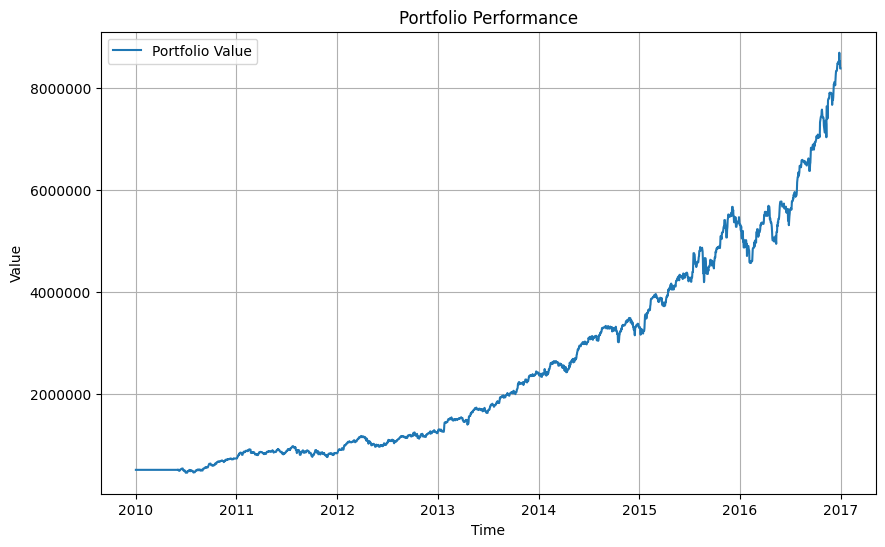

       Portfolio Value
count     2.557000e+03
mean      2.536481e+06
std       1.996511e+06
min       4.433665e+05
25%       8.685848e+05
50%       1.708498e+06
75%       3.902396e+06
max       8.699429e+06


In [63]:
from matplotlib.ticker import FormatStrFormatter

class Backtester():
    
    def __init__(self, portfolio):
        self.portfolio = portfolio
        
    def calculate_weights(self, date):
        total_weight = 0
        weights = {}
        
        for stock_name, stock in self.portfolio.stocks.items():
            try:
                weight = stock.data.loc[date]['cc_1_val']
                weights[stock_name] = weight
                total_weight += weight
            except KeyError:
                print("KE") #zzzzz
                weights[stock_name] = 0
                
        # Normalize weights
        for stock_name in weights:
            if total_weight != 0:
                weights[stock_name] /= total_weight
        print(weights)
        return weights
    
    def calculate_portfolio_value(self, date, weights, current_value):
        day_return = 0
        
        for stock_name, weight in weights.items():
            stock = self.portfolio.stocks[stock_name]
            try:
                daily_return = stock.data.loc[date]['Return']
                day_return += daily_return * weight
            except KeyError:
                continue
                
        return current_value * (1 + day_return)
    
    def run(self, start_date, end_date):
        current_date = pd.to_datetime(start_date).date()
        end_date = pd.to_datetime(end_date).date()
        values = [self.portfolio.capital]
        
        while current_date <= end_date:
            weights = self.calculate_weights(current_date)
            # Debug 
            if current_date <= pd.to_datetime('2010-01-10').date():
                print(f"Date: {current_date}, Weights: {weights}")
            port_value = self.calculate_portfolio_value(current_date, weights, values[-1])
            values.append(port_value)
            current_date += pd.Timedelta(days=1)
            
        # Plot port
        plt.figure(figsize=(10, 6))
        plt.plot(pd.date_range(start_date, end_date, freq='D'), values[1:], label="Portfolio Value") # Start plotting from the second day
        plt.title("Portfolio Performance")
        plt.xlabel("Time")
        plt.ylabel("Value")
        plt.legend()
        plt.grid(True)
        ax = plt.gca()
        ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
        
        plt.show()
        
        # stats
        df = pd.DataFrame(values[1:], index=pd.date_range(start_date, end_date, freq='D'), columns=['Portfolio Value']) # Start plotting from the second day
        print(df.describe())


backtester = Backtester(CC_RSI_portfolio)
backtester.run('2010-01-01', '2016-12-31')


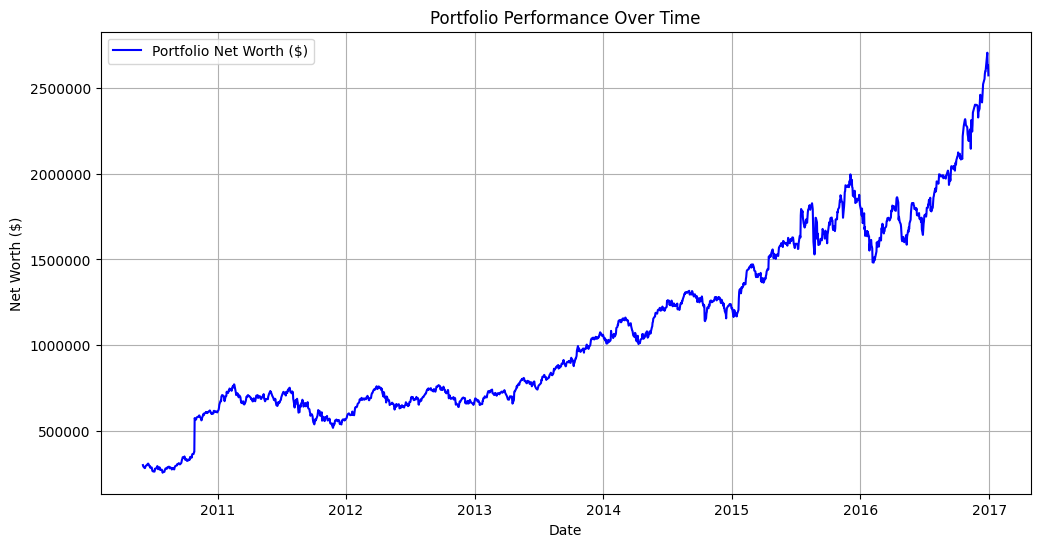

,Net Worth
Date,
2010-06-03,300000.000000
2010-06-04,292064.145859
2010-06-07,284174.666672
2010-06-08,282554.648984
2010-06-09,282860.165736
2010-06-10,291781.786137
2010-06-11,295938.652898
2010-06-14,298391.523380
2010-06-15,302768.869042


In [35]:
from matplotlib.ticker import FormatStrFormatter

# A simple backtest mechnism -> right there is no buy/sell -> just buy and hold

class Backtest():
    def __init__(self, portfolio):
        self.portfolio = portfolio
        self.positions = self.initialize_positions() # dict to track position
        self.net_worth_over_time = {}
        
    def initialize_positions(self):
        initial_investment_per_stock = self.portfolio.initial_capital / len(self.portfolio.stocks)
        positions = {}
        for stock_symbol, stock_obj in self.portfolio.stocks.items():
            positions[stock_symbol] = initial_investment_per_stock / stock_obj.data['Close_Price'].iloc[0] # buy shares @ first close price
        return positions

    def compute_net_worth(self, date):
        stock_values = [self.positions[symbol] * stock.data["Close_Price"].loc[date] for symbol, stock in self.portfolio.stocks.items() if date in stock.data.index]
        cash_value = sum(stock_values)
        return cash_value
    
    def compute_and_store_net_worth(self):
        available_dates = sorted(list(self.portfolio.stocks.values())[0].data.index)
        for date in available_dates:
            self.net_worth_over_time[date] = self.compute_net_worth(date)

    def plot_portfolio_performance(self):
        self.compute_and_store_net_worth()
        dates = sorted(self.net_worth_over_time.keys())
        net_worth = [self.net_worth_over_time[date] for date in dates]
        
        plt.figure(figsize=(12,6))
        plt.plot(dates, net_worth, label='Portfolio Net Worth ($)', color='blue')
        plt.xlabel('Date')
        plt.ylabel('Net Worth ($)')
        plt.title('Portfolio Performance Over Time')
        plt.legend()
        plt.grid(True)
        
        ax = plt.gca()
        ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
        
        plt.show()

    def get_net_worth_table(self, top_n=None):
        # dict to pd frame
        df = pd.DataFrame.from_dict(self.net_worth_over_time, orient='index', columns=['Net Worth'])
        df.index.name = 'Date'
        
        if top_n:
            display(df.head(top_n))
        else:
            display(df)

### TEST ###
bt = Backtest(CC_RSI_portfolio)
bt.plot_portfolio_performance()
bt.get_net_worth_table(top_n=10)


In [ ]:
# class Stock():

#   def __init__(self, symbol, start, end, interval, transcation_cost, strategy, verbose = True):

#     self.symbol = symbol
#     self.start = start
#     self.end = end
#     self.interval = interval
#     self.transaction_cost = transcation_cost # the transaction cost for trading
#     self.quantity = 0 # quantities to buy/sell
#     self.position = 0 # the trades in progress, long or short
#     self.trades = 0 # Number of trades
#     self.verbose = verbose # if you want to see detailed output (logs)
#     self.strategy = strategy # define the strategy

#     self.prepare_data() # prepares the data

#   def prepare_data(self):
#     # since we are building a common class for all types of strategy, we will not calcualte the moving averages now.
#     # we will calculate the returns though.
#     # Since most strategies utilise close prices we are only factoring close price. However, you can alter acoordingly.

#     stock_data = yf.Ticker(self.symbol)
#     hist_stock = stock_data.history(start = self.start, end = self.end, interval = self.interval)
#     bt_data = pd.DataFrame()
#     bt_data["Close_Price"] = hist_stock["Close"]
#     bt_data["Open_Price"] = hist_stock["Open"]
#     bt_data["Return"] = np.log(bt_data["Close_Price"] / bt_data["Close_Price"].shift(1))
#     bt_data = bt_data.dropna()
#     self.data = bt_data
    
#   def close_graph(self):
#     plt.figure(figsize=(15, 5))
#     plt.plot(self.data["Close_Price"] ,color='black', label='Price', linestyle='dashed')
#     plt.xlabel("Days")
#     plt.ylabel("Price")
#     plt.title("Close Prices of {}".format(self.symbol))
#     plt.legend()
#     plt.grid()
#     plt.show()

#   def return_date_price(self, bar):

#     # A bar is a unit of data at a given time, depends on the interval you choose, it provides you OHLCV and time info
#     # Since we have modeled close prices, we will get the price and date

#     date = str(self.data.index[bar])[:10] #First 10 contains the date elements, rest is time
#     price = self.data.Close_Price.iloc[bar]
#     return date, price

#   def load_strategy(self,num):
#     self.data = self.strategy(self.data,num)
    


#   # def realised_balance(self, bar):

#   #   #Returns you the realised capital in your account at a given time period / bar

#   #   date, price = self.return_date_price(bar)
#   #   print("Date :{} | Realised Balance: {:0.1f}".format(date,self.capital))

#   # def unrealised_balance(self, bar):

#   #   #Returns you the unrealised capital (trades in progress) in your account at a given time period / bar

#   #   date, price = self.return_date_price(bar)
#   #   ub = self.quantity *price
#   #   print("Date :{} | Unrealised Balance: {:0.1f}".format(date,ub))

#   # def total_balance(self, bar):

#   #   #Unrealised plus realised

#   #   date, price = self.return_date_price(bar)
#   #   tb = self.quantity *price + self.capital
#   #  # tb = self.quantity *price + self.capital
#   #   print("Date :{} | Total Balance: {:0.1f}".format(date,tb))

#   # def buy_order(self,bar,quantity=None, dollar =None ):
#   #   date, price = self.return_date_price(bar)
#   #   if quantity == None:
#   #     quantity = int(dollar/price)
#   #   self.capital = self.capital - ((quantity * price)*(1 + self.transaction_cost)) # capital will be lost in buying
#   #   self.quantity = self.quantity + quantity
#   #   self.trades = self.trades + 1
#   #   if self.verbose:
#   #     print("Bought {} shares of {} at {:0.1f} per share worth {:0.1f} $".format(quantity,self.symbol, price, quantity * price))
#   #     self.realised_balance(bar)
#   #     self.unrealised_balance(bar)
#   #     self.total_balance(bar)

#   #   self.data['Strategy_Value'].iloc[bar:] = self.capital + self.quantity * self.data['Close_Price'].iloc[bar]

#   # def sell_order(self,bar,quantity=None, dollar=None ):
#   #   date, price = self.return_date_price(bar)
#   #   if quantity == None:
#   #     quantity = int(dollar/price)
#   #   self.capital = self.capital + ((quantity * price)*(1 - self.transaction_cost)) # capital will be added after selling
#   #   self.quantity = self.quantity - quantity
#   #   self.trades = self.trades + 1
#   #   if self.verbose:
#   #     print("Sold {} shares of {} at {:0.1f} per share worth {:0.1f} $".format(quantity,self.symbol, price, quantity * price))
#   #     self.realised_balance(bar)
#   #     self.unrealised_balance(bar)
#   #     self.total_balance(bar)
#   #   self.data['Strategy_Value'].iloc[bar:] = self.capital + self.quantity * self.data['Close_Price'].iloc[bar]

#   # def compute_sharpe_ratio(self):
#   #     avg_returns = self.data['Strategy_Returns'].mean()
#   #     std = self.data['Strategy_Returns'].std()
#   #     daily_SR = avg_returns / std
#   #     annual_SR = daily_SR * (252 ** 0.5)
#   #     return round(annual_SR, 2)
  
#   # def compute_drawdown(self):
#   #     cum_returns = (1 + self.data['Strategy_Returns']).cumprod()
#   #     peak = cum_returns.expanding(min_periods=1).max()
#   #     drawdown = (cum_returns / peak) - 1
#   #     return round(drawdown.min(), 2)

#   # def compute_calmar_ratio(self):
#   #     annual_return = (1 + self.data['Strategy_Returns']).prod() ** (252 / len(self.data)) - 1
#   #     max_drawdown = self.compute_drawdown()
#   #     if max_drawdown < 0:
#   #         calmar = annual_return / abs(max_drawdown)
#   #     else:
#   #         calmar = np.nan
#   #     return round(calmar, 2)


#   # def last_trade(self, bar):
#   #   date, price = self.return_date_price(bar)
#   #   last_quantity = self.quantity # this variable to print and store as self.quantity will be set to 0 later
#   #   self.capital = self.capital + self.quantity * price
#   #   self.quantity = 0 # as no more quantity now. all will be settled
#   #   self.trades = self.trades +1
#   #   self.data['Strategy_Value'].iloc[bar:] = self.capital

#   #   if self.verbose:
#   #     print("Closed open trades for {} shares of {} at {:0.1f} per share worth {:0.1f} $".format(last_quantity,self.symbol, price, last_quantity * price))
#   #     self.total_balance(bar)

#   #     returns = (self.capital - self.initial_capital) /self.initial_capital *100
#   #     print("The total capital at end of strategy: {:0.1f}".format(self.capital))
#   #     print( "The strategy returns on investment are {:0.1f} %".format(returns))
#   #     print( "Total trades by startegy are {:0.1f}".format(self.trades))
#   #     print( "Sharpe Ratio: {:0.1f}".format(self.compute_sharpe_ratio()))
#   #     print( "Max Drawdown: {:0.1f}".format(self.compute_drawdown()))
#   #     print( "Calmar Ratio: {:0.1f}".format(self.compute_calmar_ratio()))


In [ ]:
# class Momentum_Strategy(Common_Class):

#   def go_long(self, bar, quantity = None, dollar = None):
#     if self.position == -1:
#       self.buy_order(bar, quantity = -self.quantity) # to clear previous short position and therefore negative quantity
#     if quantity:
#       self.buy_order(bar, quantity=quantity) # to create new fresh order
#     elif dollar:
#       if dollar == "all":
#         dollar = self.capital
#       self.buy_order(bar,dollar=dollar)
      
#   def go_short(self, bar, quantity = None, dollar = None):
#     if self.position == 1:
#       self.sell_order(bar, quantity = self.quantity) # to clear previous long position
#     if quantity:
#       self.sell_order(bar, quantity=quantity) # to create new fresh order
#     elif dollar:
#       if dollar == "all":
#         dollar = self.capital
#       self.sell_order(bar,dollar=dollar)  

#   def run_strategy(self, STMA_window, LTMA_window):
#     self.position = 0
#     self.trades = 0
#     self.capital = self.initial_capital
#     indicator_1 = SMAIndicator (close = self.data["Close_Price"], window = STMA_window, fillna= False)
#     STMA = indicator_1.sma_indicator()
#     indicator_2 = SMAIndicator (close = self.data["Close_Price"], window = LTMA_window, fillna= False)
#     LTMA = indicator_2.sma_indicator ()

#     self.data["STMA"] = STMA
#     self.data["LTMA"] = LTMA

#     for bar in range(LTMA_window, len(self.data)):
#       if self.position in [0, -1]: # checking no position or short position 1f self. data ["STMA*].11oc [bar]›self. data ["LTMA"].11oc [bar]: self.go_long(bar, dollar-"all") # go with all money self.position - 1 # long created print("
#         if self.data['STMA'].iloc[bar] > self.data['LTMA'].iloc[bar]:
#           self.go_long(bar, dollar = "all")
#           self.position = 1
#           print('-------')
#       if self.position in [0,1]:
#         if self.data['STMA'].iloc[bar] < self.data['LTMA'].iloc[bar]:
#           self.go_short(bar,dollar = "all")
#           self.position = -1
#           print('-------')
#     print('-------')

#     self.data['Strategy_Returns'] = self.data['Strategy_Value'].pct_change()

#     self.last_trade(bar)
    